# Dermatology Dataset Preparation

In this section, we will:
- Load and inspect the dataset
- Perform missing value analysis and basic EDA
- Impute missing values
- Split the data into 16 subsets
- Visualize the distribution of classes among subsets


In [8]:
# 1. IMPORTS & SETTINGS
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# for consistent plots in notebooks
%matplotlib inline

In [9]:
# 2. LOAD DERMATOLOGY DATASET
# Column names from UCI description
cols = [
    'erythema', 'scaling', 'definite_borders', 'itching', 'koebner_phenomenon',
    'polygonal_papules', 'follicular_papules', 'oral_mucosal_involvement',
    'knee_and_elbow_involvement', 'scalp_involvement', 'family_history',
    'melanin_incontinence', 'eosinophils_infiltrate', 'PNL_infiltrate',
    'fibrosis_papillary_dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis',
    'parakeratosis', 'clubbing_rete_ridges', 'elongation_rete_ridges',
    'thinning_suprapapillary_epidermis', 'spongiform_pustule',
    'munro_microabcess', 'focal_hypergranulosis', 'disappearance_granular_layer',
    'vacuolisation_damage', 'spongiosis', 'saw_tooth_appearance',
    'follicular_horn_plug', 'perifollicular_parakeratosis', 'inflammatory_monoluclear_inflitrate',
    'band_like_infiltrate', 'age', 'class'
]

# Load the data, treating '?' as missing values
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data'
df = pd.read_csv(url, names=cols, na_values='?')

print(f"Total samples: {len(df)}")
df.head()

Total samples: 366


,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_granular_layer,vacuolisation_damage,spongiosis,saw_tooth_appearance,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55.0,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8.0,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26.0,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40.0,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45.0,3



Missing values per column:
erythema                               0
scaling                                0
definite_borders                       0
itching                                0
koebner_phenomenon                     0
polygonal_papules                      0
follicular_papules                     0
oral_mucosal_involvement               0
knee_and_elbow_involvement             0
scalp_involvement                      0
family_history                         0
melanin_incontinence                   0
eosinophils_infiltrate                 0
PNL_infiltrate                         0
fibrosis_papillary_dermis              0
exocytosis                             0
acanthosis                             0
hyperkeratosis                         0
parakeratosis                          0
clubbing_rete_ridges                   0
elongation_rete_ridges                 0
thinning_suprapapillary_epidermis      0
spongiform_pustule                     0
munro_microabcess            

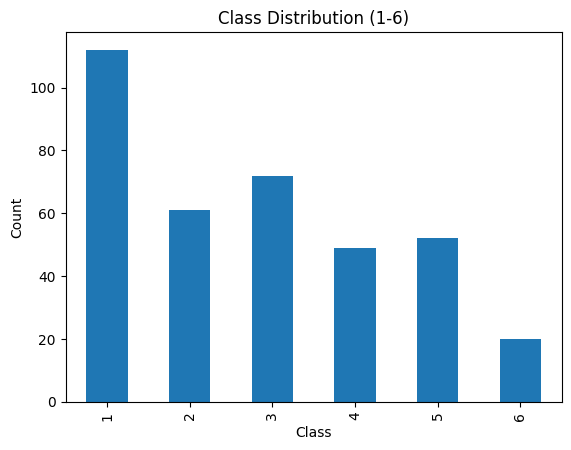

In [10]:
# 3. INSPECT MISSING VALUES & CLASS DISTRIBUTION
print("\nMissing values per column:")
print(df.isna().sum())

print("\nClass distribution (1-6, see UCI for disease types):")
print(df['class'].value_counts())

# Bar chart of class balance
df['class'].value_counts().sort_index().plot.bar(title="Class Distribution (1-6)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

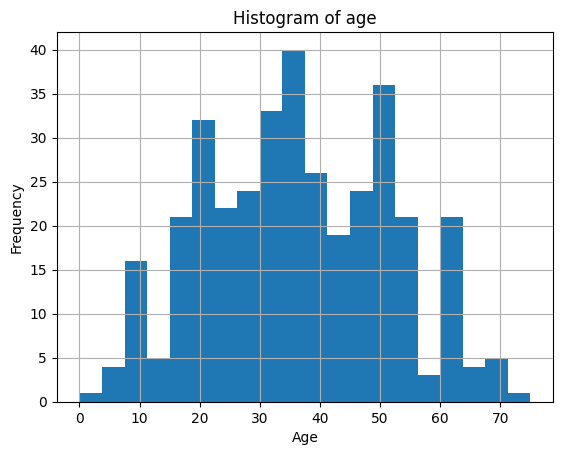

In [11]:
# 4. AGE FEATURE DISTRIBUTIONS
# Plot histograms for age feature since it has missing values
plt.figure()
df['age'].hist(bins=20)
plt.title(f"Histogram of age")
plt.xlabel('Age')
plt.ylabel("Frequency")
plt.show()

The **age** feature, being a non-continuous numerical variable and typically regarded as a naturally distributed attribute, exhibits an unusually uneven distribution in its histogram. While the distribution peaks near the center, there are a considerable number of static values and outliers, particularly around the ages of *10*, *20*, *50*, and *60*. This phenomenon may be attributed to certain disease classes predominantly affecting specific age groups. Consequently, **class-wise imputation** for the *age* feature is warranted to ensure both reliability and accuracy in subsequent analyses.

In [12]:
# 5. IMPUTE MISSING VALUES CLASS-WISE FOR 'age'
X = df.drop('class', axis=1)
y = df['class']

X_imputed = X.copy()

# Impute 'age' by class-wise median
for cls in y.unique():
    mask = (y == cls)
    age_median = X.loc[mask, 'age'].median()
    X_imputed.loc[mask & X['age'].isna(), 'age'] = age_median

# Verify no missing values remain
print("\nMissing after imputation:")
print(X_imputed.isna().sum())



Missing after imputation:
erythema                               0
scaling                                0
definite_borders                       0
itching                                0
koebner_phenomenon                     0
polygonal_papules                      0
follicular_papules                     0
oral_mucosal_involvement               0
knee_and_elbow_involvement             0
scalp_involvement                      0
family_history                         0
melanin_incontinence                   0
eosinophils_infiltrate                 0
PNL_infiltrate                         0
fibrosis_papillary_dermis              0
exocytosis                             0
acanthosis                             0
hyperkeratosis                         0
parakeratosis                          0
clubbing_rete_ridges                   0
elongation_rete_ridges                 0
thinning_suprapapillary_epidermis      0
spongiform_pustule                     0
munro_microabcess             

In [13]:
# 7. CREATE 16 SUBSETS FOR ALL TRAIN/TEST RATIOS (EXPLICIT VARIABLE NAMES)

# Shuffle the dataset first
X_shuffled, y_shuffled = shuffle(X_imputed, y, random_state=42)

# 40/60 split
feature_train_40_60, feature_test_40_60, label_train_40_60, label_test_40_60 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.4, test_size=0.6, stratify=y_shuffled, random_state=42
)
# 60/40 split
feature_train_60_40, feature_test_60_40, label_train_60_40, label_test_60_40 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.6, test_size=0.4, stratify=y_shuffled, random_state=42
)
# 80/20 split
feature_train_80_20, feature_test_80_20, label_train_80_20, label_test_80_20 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.8, test_size=0.2, stratify=y_shuffled, random_state=42
)
# 90/10 split
feature_train_90_10, feature_test_90_10, label_train_90_10, label_test_90_10 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.9, test_size=0.1, stratify=y_shuffled, random_state=42
)

# Print sample sizes and class balance for each split
splits = [
    ("40/60", feature_train_40_60, feature_test_40_60, label_train_40_60, label_test_40_60),
    ("60/40", feature_train_60_40, feature_test_60_40, label_train_60_40, label_test_60_40),
    ("80/20", feature_train_80_20, feature_test_80_20, label_train_80_20, label_test_80_20),
    ("90/10", feature_train_90_10, feature_test_90_10, label_train_90_10, label_test_90_10),
]
for ratio, X_tr, X_te, y_tr, y_te in splits:
    print(f"\nSplit {ratio}:")
    print(f"  Train samples: {len(X_tr)}, Test samples: {len(X_te)}")
    print("  Train class balance:")
    print(y_tr.value_counts(normalize=True))
    print("  Test class balance:")
    print(y_te.value_counts(normalize=True))

# Now you have 16 variables: feature_train_40_60, label_train_40_60, feature_test_40_60, label_test_40_60, etc.
# Each set corresponds to a different train/test split ratio, and all splits are stratified and shuffled.


Split 40/60:
  Train samples: 146, Test samples: 220
  Train class balance:
class
1    0.308219
3    0.198630
2    0.164384
5    0.143836
4    0.130137
6    0.054795
Name: proportion, dtype: float64
  Test class balance:
class
1    0.304545
3    0.195455
2    0.168182
5    0.140909
4    0.136364
6    0.054545
Name: proportion, dtype: float64

Split 60/40:
  Train samples: 219, Test samples: 147
  Train class balance:
class
1    0.305936
3    0.196347
2    0.168950
5    0.141553
4    0.132420
6    0.054795
Name: proportion, dtype: float64
  Test class balance:
class
1    0.306122
3    0.197279
2    0.163265
5    0.142857
4    0.136054
6    0.054422
Name: proportion, dtype: float64

Split 80/20:
  Train samples: 292, Test samples: 74
  Train class balance:
class
1    0.304795
3    0.195205
2    0.167808
5    0.143836
4    0.133562
6    0.054795
Name: proportion, dtype: float64
  Test class balance:
class
1    0.310811
3    0.202703
2    0.162162
4    0.135135
5    0.135135
6    0.054054

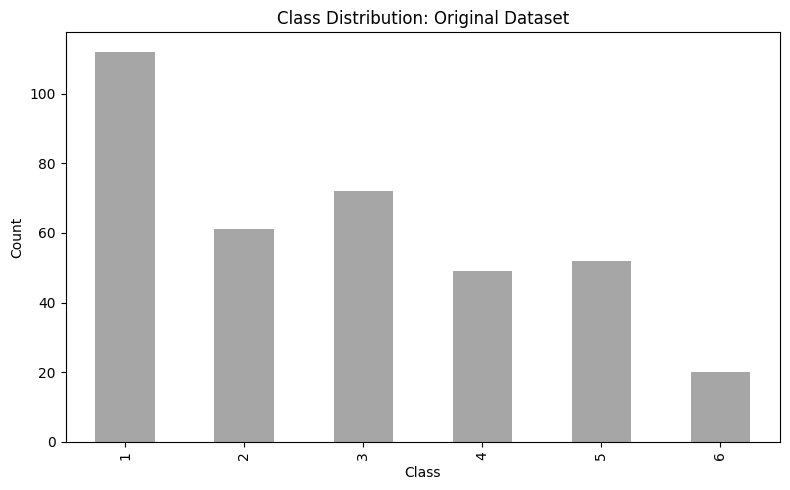

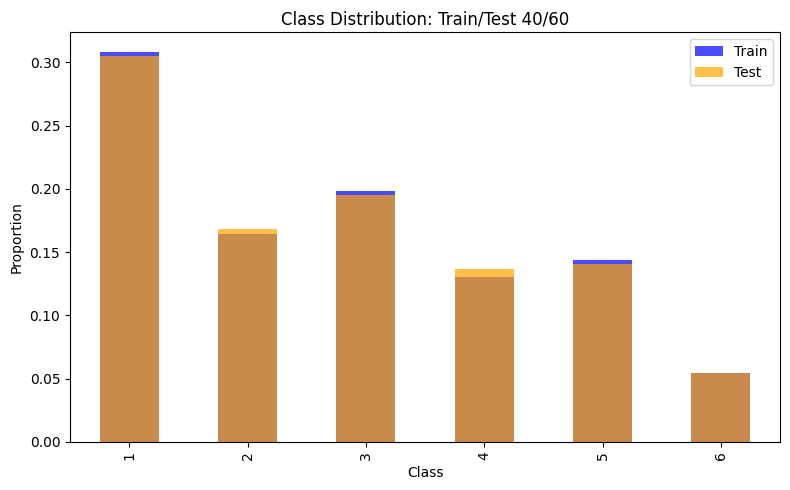

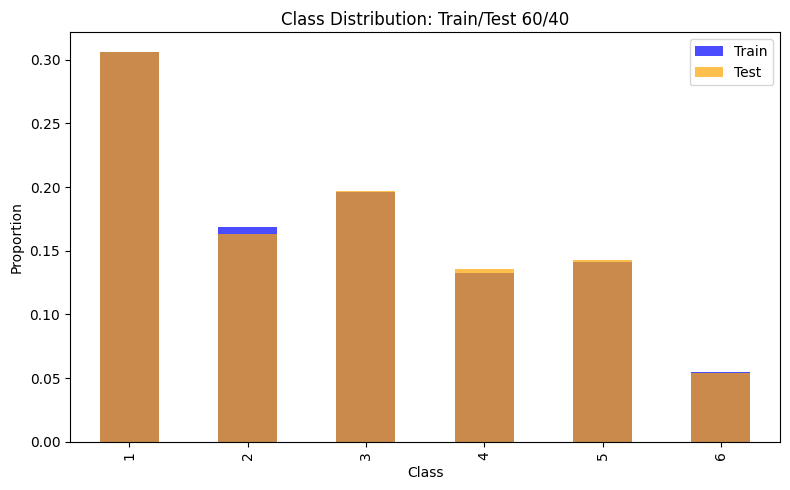

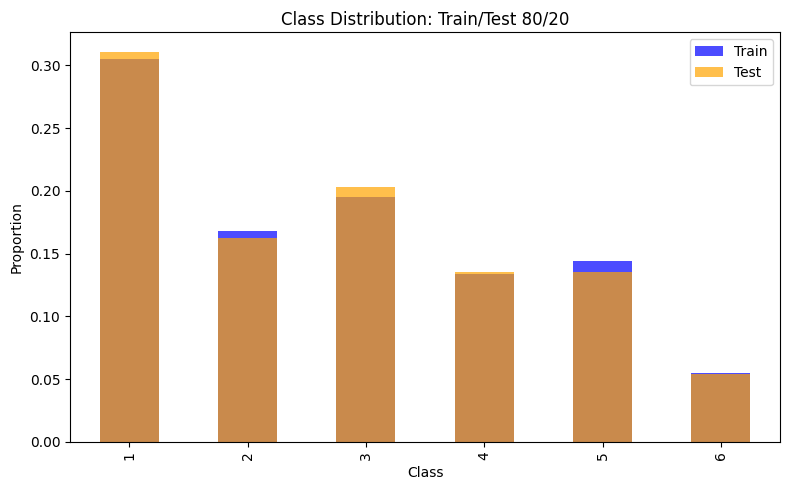

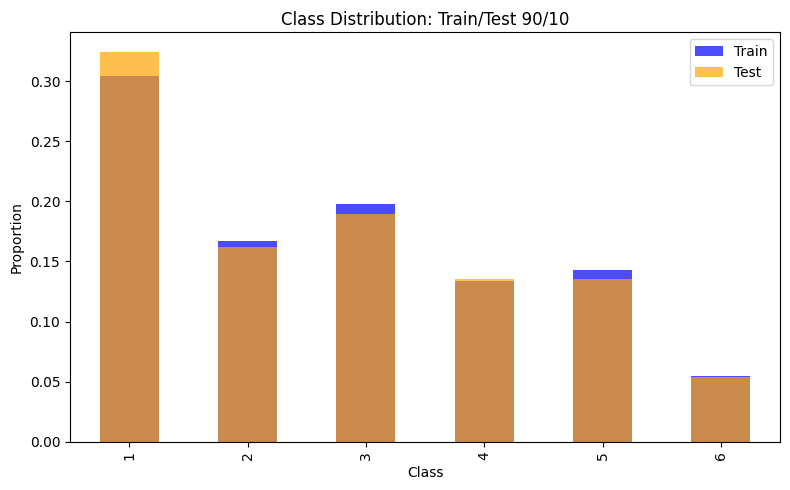

In [14]:
# 8. VISUALIZE CLASS DISTRIBUTIONS

splits = [
    ("40/60", label_train_40_60, label_test_40_60),
    ("60/40", label_train_60_40, label_test_60_40),
    ("80/20", label_train_80_20, label_test_80_20),
    ("90/10", label_train_90_10, label_test_90_10),
]

# Plot original distribution
plt.figure(figsize=(8, 5))
y.value_counts().sort_index().plot(kind='bar', color='gray', alpha=0.7)
plt.title("Class Distribution: Original Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot train/test distributions for each split
for ratio, y_train, y_test in splits:
    plt.figure(figsize=(8, 5))
    y_train.value_counts(normalize=True).sort_index().plot(kind='bar', alpha=0.7, label='Train', color='blue')
    y_test.value_counts(normalize=True).sort_index().plot(kind='bar', alpha=0.7, label='Test', color='orange')
    plt.title(f"Class Distribution: Train/Test {ratio}")
    plt.xlabel("Class")
    plt.ylabel("Proportion")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Next Steps:**  
After running this data preparation script _(reaching here)_, please proceed to `03_additional_dataset_models_evaluation.ipynb` to create and evaluate classification models.  
**Important:** These two notebooks are designed to be used within the same session to ensure all variables and data splits remain available for modeling and evaluation.